In [1]:
import numpy as np
import gym
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip3 install swig
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip install gym[box2d]

  Obtaining dependency information for swig from https://files.pythonhosted.org/packages/89/57/aec312f259b202185481a4c688d517dd62c40723695b3d04b851e682aa4e/swig-4.1.1.post1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=494637 sha256=96a9e02341c53cece44073c4c766e4508b4805f49ba9057eccf8167fb5876a51
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.

In [3]:
env = gym.make('LunarLander-v2')

In [4]:
class replayBuffer:
  def __init__(self,maxSize,stateDim):
    self.state=np.zeros((maxSize,stateDim))
    self.action=np.zeros(maxSize,dtype= np.int8)
    self.reward=np.zeros(maxSize)
    self.done=np.zeros(maxSize,)
    self.nextState=np.zeros((maxSize,stateDim))
    self.maxSize=maxSize
    self.curser=0
    self.size=0

  def save(self,state,action,reward,nextState,done):
    self.state[self.curser]=state
    self.action[self.curser]=action
    self.reward[self.curser]=reward
    self.nextState[self.curser]=nextState
    self.done[self.curser]=done
    self.curser=(self.curser+1)%self.maxSize
    if self.size<self.maxSize:
      self.size+=1

  def sample(self,batchSize):
    batchSize=min(self.size,batchSize-1)
    indexes=np.random.choice([i for i in range(self.size-1)],batchSize)
    return self.state[indexes],self.action[indexes],self.reward[indexes],self.nextState[indexes],self.done[indexes]


In [5]:
class Agent:
  def __init__(self,stateShape,actionShape,exploreRate,exploreRateDecay,minimumExploreRate,gamma,copyNetsCycle):
      self.gamma=gamma
      self.exploreRate=exploreRate
      self.exploreRateDecay=exploreRateDecay
      self.minimumExploreRate=minimumExploreRate
      self.actionShape=actionShape
      self.memory=replayBuffer(1000000,stateShape)
      self.model=self.buildModel(stateShape,actionShape)
      self.model.compile(optimizer='Adam',loss='mse')
      self.tModel=self.buildModel(stateShape,actionShape)
      self.tModel.compile(optimizer='Adam',loss='mse')
      self.learnThreshold=0
      self.copyNetsCycle=copyNetsCycle

  def buildModel(self,input,output):
    inputLayer=keras.Input(shape=(input,))
    layer=Dense(256,activation='relu')(inputLayer)
    layer=Dense(256,activation='relu')(layer)
    outputLayer=Dense(output)(layer)
    model=keras.Model(inputs=inputLayer,outputs=outputLayer)
    model.compile(optimizer='Adam',loss='mse')
    return model

  def getAction(self,state,evaluation_mode=False):
    q=self.model(np.expand_dims(state,axis=0))[0].numpy()
    if np.random.random()<=self.exploreRate and (not(evaluation_mode)):
      return np.random.choice([i for i in range(env.action_space.n)])
    else:
      return np.argmax(q)

  def exploreDecay(self):
      self.exploreRate=max(self.exploreRate*self.exploreRateDecay,self.minimumExploreRate)

  def saveModel(self,modelName="DoubleDQN_LunarLanderV2.h"):
      self.model.save_weights(f"{modelName}")

  def loadModel(self,modelName="DoubleDQN_LunarLanderV2.h"):
      self.model.load_weights(f"{modelName}")
      self.tModel.set_weights(self.model.get_weights())

  def learn(self,batchSize=64):
    if self.memory.size>batchSize:
      states,actions,rewards,nextStates,done=self.memory.sample(batchSize)
      qState=self.model(states).numpy()
      qNextState=self.model(nextStates).numpy()
      qNextStateTarget=self.tModel(nextStates).numpy()
      maxActions=np.argmax(qNextState,axis=1)
      batchIndex = np.arange(batchSize-1, dtype=np.int32)
      qState[batchIndex,actions]=(rewards+(self.gamma*qNextStateTarget[batchIndex,maxActions.astype(int)]*(1-done)))
      _=self.model.fit(x=states,y=qState,verbose=0)
      self.learnThreshold+=1
      self.exploreDecay()
      if(self.learnThreshold%self.copyNetsCycle)==0:
        self.tModel.set_weights(self.model.get_weights())
        self.saveModel()
        self.learnThreshold=0
agent=Agent(stateShape=env.observation_space.shape[0],actionShape=env.action_space.n\
            ,exploreRate=0.01,exploreRateDecay=0.99,minimumExploreRate=0.01,gamma=0.99,copyNetsCycle=100)

In [6]:
agent=Agent(stateShape=env.observation_space.shape[0],actionShape=env.action_space.n\
            ,exploreRate=1.0,exploreRateDecay=0.9995,minimumExploreRate=0.01,gamma=0.99,copyNetsCycle=100)
# agent.loadModel("DoubleDQN_LunarLanderV2.h")

In [7]:
averageRewards=[]
totalRewards=[]
for i in range(1,200):
  done = False
  truncuated = False
  state,_=env.reset()
  rewards=0
  while (not done) and (not truncuated):
    action=agent.getAction(state)
    nextState,reward,done,truncuated,_=env.step(action)
    agent.memory.save(state,action,reward,nextState,int(done))
    rewards+=reward
    state=nextState
    agent.learn(batchSize=64)
  totalRewards.append(rewards)
  averageRewards.append(sum(totalRewards)/len(totalRewards))
  print(f"episode: {i+1}   reward: {rewards}  avg so far:{averageRewards[-1]} exploreRate:{agent.exploreRate}")

/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 2   reward: -123.4838284048032  avg so far:-123.4838284048032 exploreRate:0.9860940917766235
episode: 3   reward: -120.2480775877887  avg so far:-121.86595299629596 exploreRate:0.9333105749632893
episode: 4   reward: -124.38843377713812  avg so far:-122.70677992324335 exploreRate:0.8985016297353923
episode: 5   reward: -172.6867510698475  avg so far:-135.20177270989439 exploreRate:0.8542431659050345
episode: 6   reward: -185.0293336390434  avg so far:-145.1672848957242 exploreRate:0.821971943634938
episode: 7   reward: -37.67185613154821  avg so far:-127.25138010169486 exploreRate:0.7948853455740398
episode: 8   reward: -268.06423176214395  avg so far:-147.36750176747333 exploreRate:0.7561088752427627
episode: 9   reward: -425.7797816503208  avg so far:-182.16903675282924 exploreRate:0.717786647345383
episode: 10   reward: -11.2537898917019  avg so far:-163.17845376825954 exploreRate:0.6834545255907595
episode: 11   reward: -238.72555770217554  avg so far:-170.73316416165113 e

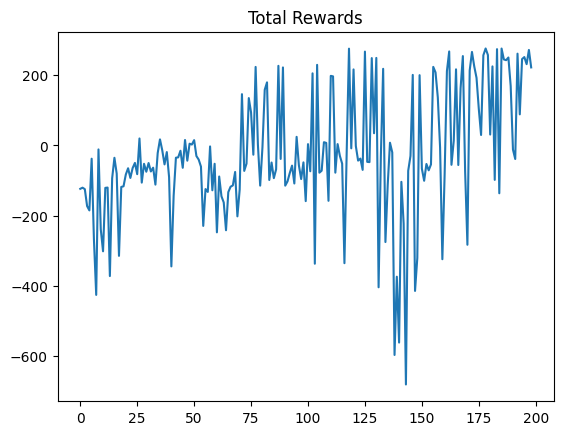

In [8]:
plt.title(f'Total Rewards')
# plt.yscale('symlog')
plt.plot(totalRewards)
plt.savefig("Total Rewards",dpi=200)


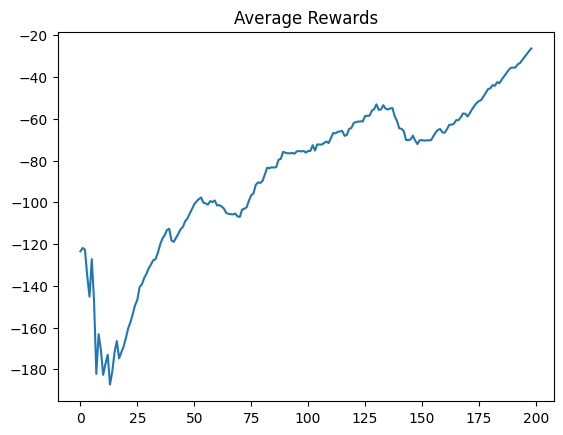

In [9]:
plt.clf()
plt.title(f'Average Rewards')
# plt.yscale('symlog')
plt.plot(averageRewards)
plt.savefig("Average Rewards",dpi=200)

In [10]:
# test loop for 10 diffrent episodeds
sum_evaluation_rewards=0
for i in range(0,20):
  done = False
  truncuated = False
  state,_=env.reset()
  rewards=0
  while (not done) and (not truncuated):
    action=agent.getAction(state,True)
    nextState,reward,done,truncuated,_=env.step(action)
    rewards+=reward
    state=nextState
    # no learning we want to test the model
  print(f" Test episode: {i+1}   gained reward: {rewards}")
  sum_evaluation_rewards+=rewards
print(f"average of evaluation rewards: {sum_evaluation_rewards/20}")

 Test episode: 1   gained reward: 256.3287448846416
 Test episode: 2   gained reward: -266.5255463715048
 Test episode: 3   gained reward: -83.38799896225918
 Test episode: 4   gained reward: -209.25251056503032
 Test episode: 5   gained reward: 248.78689041237715
 Test episode: 6   gained reward: 237.58942444329242
 Test episode: 7   gained reward: 205.72654972013942
 Test episode: 8   gained reward: 131.55612561734586
 Test episode: 9   gained reward: 177.84647690540885
 Test episode: 10   gained reward: 266.44505495238855
 Test episode: 11   gained reward: 199.5909098097983
 Test episode: 12   gained reward: 262.34798168296544
 Test episode: 13   gained reward: 247.7073683864242
 Test episode: 14   gained reward: 227.58019588952845
 Test episode: 15   gained reward: -269.1541025698533
 Test episode: 16   gained reward: 261.7617897090562
 Test episode: 17   gained reward: -10.381268442657055
 Test episode: 18   gained reward: 283.84203770769
 Test episode: 19   gained reward: 210.279